In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore") 
import math
import seaborn as sns
from pandas.plotting import scatter_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error

## Load Data

In [2]:
#https://www.google.com/covid19/mobility/
url = 'https://drive.google.com/file/d/18gyHbx6rfogq3yQ-GR9COjcGgyYlCnBZ/view?usp=sharing'
url2020 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
url = 'https://drive.google.com/file/d/1Eg8Lffm49bc-bGFkv_4ddrQw8U8WE6P4/view?usp=sharing'
url2021 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
df20 = pd.read_csv(url2020)
df21 = pd.read_csv(url2021)

**retail_and_recreation_percent_change_from_baseline**

Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

**grocery_and_pharmacy_percent_change_from_baseline**

Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.

**parks_percent_change_from_baseline**

Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.

**transit_stations_percent_change_from_baseline**

Mobility trends for places like public transport hubs such as subway, bus, and train stations.

**workplaces_percent_change_from_baseline**

Mobility trends for places of work.


In [4]:
#df20.info()
#df21.info()

In [5]:
frames = [df20, df21]
g_mob=pd.concat(frames)
g_mob.index=range(0,len(g_mob))
#g_mob.info()
#g_mob.head()


In [6]:
g_mob=g_mob[["date",
             "retail_and_recreation_percent_change_from_baseline",
             "grocery_and_pharmacy_percent_change_from_baseline",
             "parks_percent_change_from_baseline",
             "transit_stations_percent_change_from_baseline",
             "workplaces_percent_change_from_baseline"]]
g_mob.rename(columns={
             "date":"date",
             "retail_and_recreation_percent_change_from_baseline":"restaurants_cafes" ,
             "grocery_and_pharmacy_percent_change_from_baseline":"grocery_pharmacies" ,
             "parks_percent_change_from_baseline":"parks" ,
             "transit_stations_percent_change_from_baseline":"subway_train" ,
             "workplaces_percent_change_from_baseline":"workplaces" 
}, 
             inplace=True);

### __Looking for Correlations__

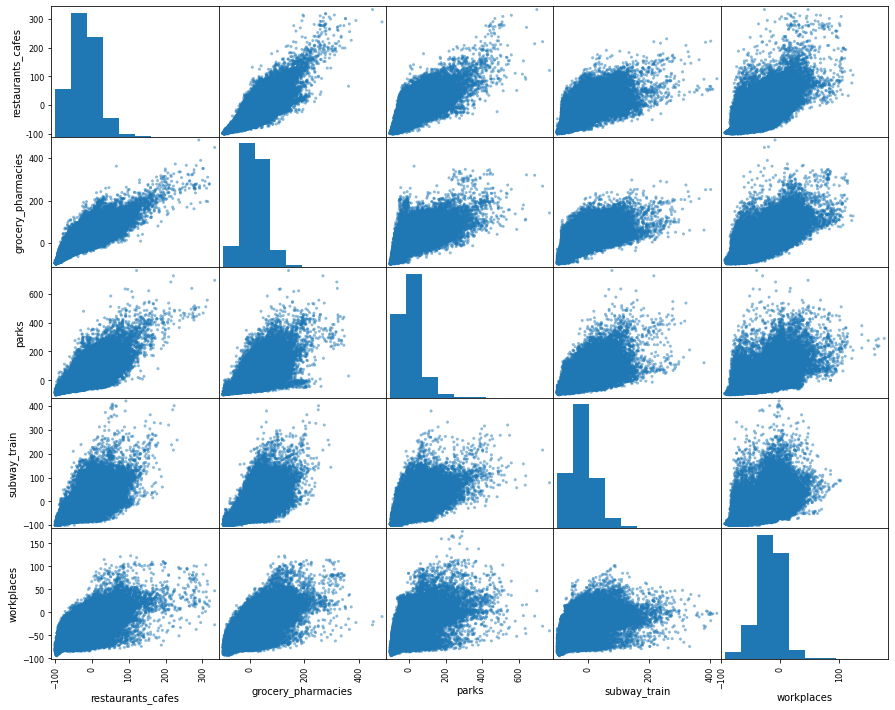

In [7]:
scatter_matrix(g_mob, figsize=(15, 12));

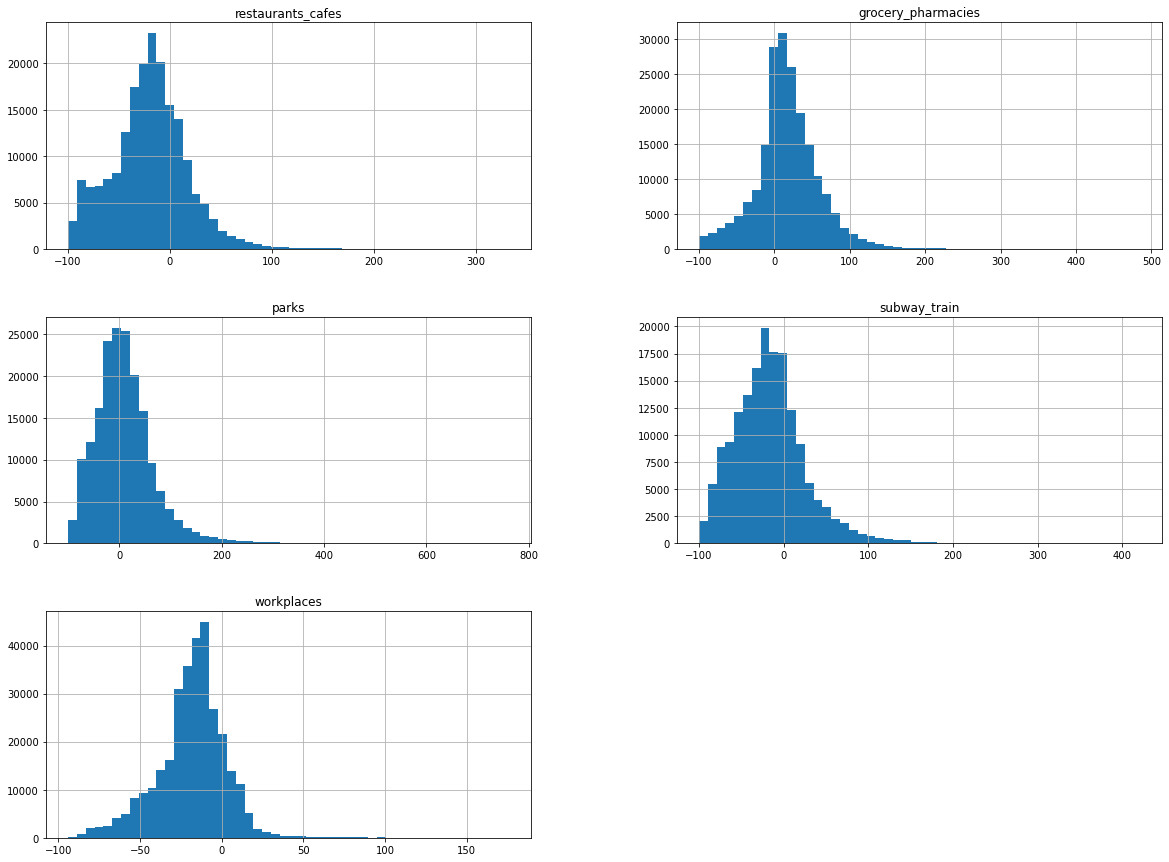

In [8]:
g_mob[["restaurants_cafes",
    "grocery_pharmacies",
    "parks",
    "subway_train",
    "workplaces" ]].hist(bins=50, figsize=(20,15))
plt.title("mobility data histogram grafiği")
plt.show()

In [9]:
g_mob

,date,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
0,2020-02-15,2.0,3.0,-11.0,-4.0,7.0
1,2020-02-16,7.0,6.0,14.0,2.0,5.0
2,2020-02-17,6.0,5.0,10.0,5.0,8.0
3,2020-02-18,4.0,6.0,11.0,4.0,8.0
4,2020-02-19,0.0,3.0,6.0,0.0,9.0
...,...,...,...,...,...,...
326082,2021-10-01,-12.0,101.0,NaN,-17.0,-15.0
326083,2021-10-02,-14.0,65.0,NaN,-9.0,-17.0
326084,2021-10-03,-20.0,NaN,NaN,-19.0,-24.0
326085,2021-10-04,-8.0,111.0,NaN,-4.0,-15.0


#### Biraz inceledikten sonra bazı veri ön işleme adımlarını gerçekleştirmemiz gerektiği görüldü
- Bazı columnlarda fazla sayıda eksik değer var. Bu eksik değerler knn ile doldurulacak. 
- Tarihlere göre mobility değişimini hakkında bir içgörü kazanmak adına verileri görselleştireceğiz. Bununla birlikte, bu görselleştirmeye "covid ölümleri" ni de dahil edersek faydalı lacak. O yüzden Covid- ölüm datasını bu dataya ekleyeceğiz.

__Eksik gözlem analizi__  

heat map'a bakınca, eksik verilerin birçoğunun birbiriyle ilişkili şekidle eksik olabileceğini, yani bir gözlemin eksik olmasına sebep olan şeyi ngenelde diğerlerinin de eksik olmasına sebep olabileceğini görüyoruz. 


<AxesSubplot:>

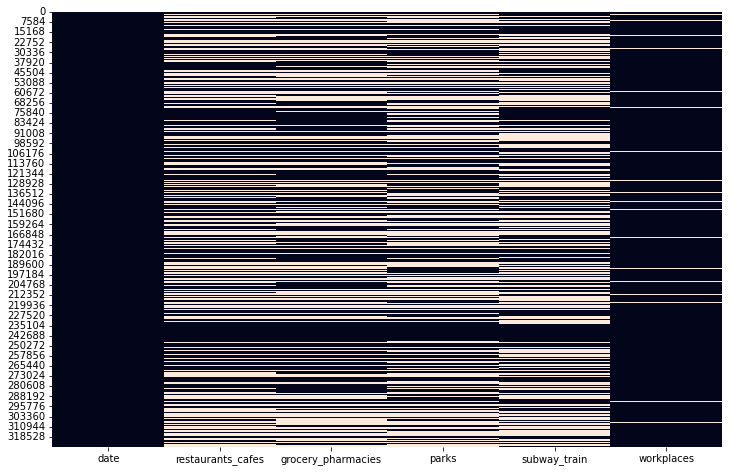

In [10]:
plt.figure(figsize=(12,8))

sns.heatmap(g_mob.isnull(),cbar=False)

In [11]:
g_mob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326087 entries, 0 to 326086
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                326087 non-null  object 
 1   restaurants_cafes   193035 non-null  float64
 2   grocery_pharmacies  198593 non-null  float64
 3   parks               182285 non-null  float64
 4   subway_train        166532 non-null  float64
 5   workplaces          313542 non-null  float64
dtypes: float64(5), object(1)
memory usage: 14.9+ MB


Eksik verilerin doldurulması için 

<AxesSubplot:>

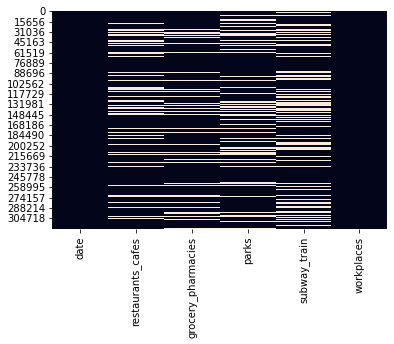

In [12]:
g_mob=g_mob[g_mob.isnull().sum(axis=1)<4]
sns.heatmap(g_mob.isnull(),cbar=False)

In [13]:
#!pip install ycimpute
from ycimpute.imputer import knnimput
names=list(g_mob)
nparray_df=np.array(g_mob.iloc[:, 1:])
nparray_df.shape

(238222, 5)

In [14]:
features_to_fill=["restaurants_cafes","grocery_pharmacies","parks","subway_train","workplaces"]
filled_df_array=np.zeros(nparray_df.shape)
curr=0
row_size_of_g_mob=g_mob.shape[0]
for i in np.arange(5000, row_size_of_g_mob,5000):
    if(np.any(np.isnan(nparray_df[curr:i][:]))):
        filled_df_array[curr:i]=knnimput.KNN(k = 37).complete(nparray_df[curr:i][:]);
    curr=i

if(np.any(np.isnan(nparray_df[curr:][:]))):
    filled_df_array[curr:]=knnimput.KNN(k = 37).complete(nparray_df[curr:row_size_of_g_mob][:]);

Imputing row 1/5000 with 0 missing, elapsed time: 2.373
Imputing row 101/5000 with 0 missing, elapsed time: 2.374
Imputing row 201/5000 with 0 missing, elapsed time: 2.374
Imputing row 301/5000 with 0 missing, elapsed time: 2.374
Imputing row 401/5000 with 0 missing, elapsed time: 2.374
Imputing row 501/5000 with 0 missing, elapsed time: 2.375
Imputing row 601/5000 with 0 missing, elapsed time: 2.375
Imputing row 701/5000 with 0 missing, elapsed time: 2.376
Imputing row 801/5000 with 0 missing, elapsed time: 2.376
Imputing row 901/5000 with 0 missing, elapsed time: 2.377
Imputing row 1001/5000 with 0 missing, elapsed time: 2.377
Imputing row 1101/5000 with 0 missing, elapsed time: 2.378
Imputing row 1201/5000 with 0 missing, elapsed time: 2.380
Imputing row 1301/5000 with 1 missing, elapsed time: 2.382
Imputing row 1401/5000 with 1 missing, elapsed time: 2.386
Imputing row 1501/5000 with 1 missing, elapsed time: 2.390
Imputing row 1601/5000 with 1 missing, elapsed time: 2.394
Imputing 

In [97]:
g_mob_filled=g_mob.copy()
print(g_mob_filled.isnull().values.any())
g_mob_filled.iloc[:][features_to_fill]=filled_df_array
print(g_mob_filled.isnull().values.any())
g_mob_filled=g_mob_filled.groupby(by="date").sum()
g_mob_filled

True
False


,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
date,,,,,
2020-02-15,990.586960,2021.818428,-1561.064646,-3432.781956,2513.339185
2020-02-16,2157.402309,2793.079903,2942.536856,-352.246128,1648.148485
2020-02-17,2195.364769,2882.388673,4042.843759,-1556.512792,3750.531599
2020-02-18,2231.546460,2701.294371,4990.731847,-1524.334450,4028.878007
2020-02-19,822.529543,1433.273366,3709.403282,-2289.695958,3981.488310
...,...,...,...,...,...
2021-10-01,10032.138595,28341.801322,17388.032059,9703.307668,1276.000000
2021-10-02,9180.330620,23201.766227,16160.184049,9010.811752,689.000000
2021-10-03,6788.159097,18521.319688,17286.890103,7815.287463,-625.000000


In [16]:
g_mob_filled.isnull().sum()

restaurants_cafes     0
grocery_pharmacies    0
parks                 0
subway_train          0
workplaces            0
dtype: int64

# görseller

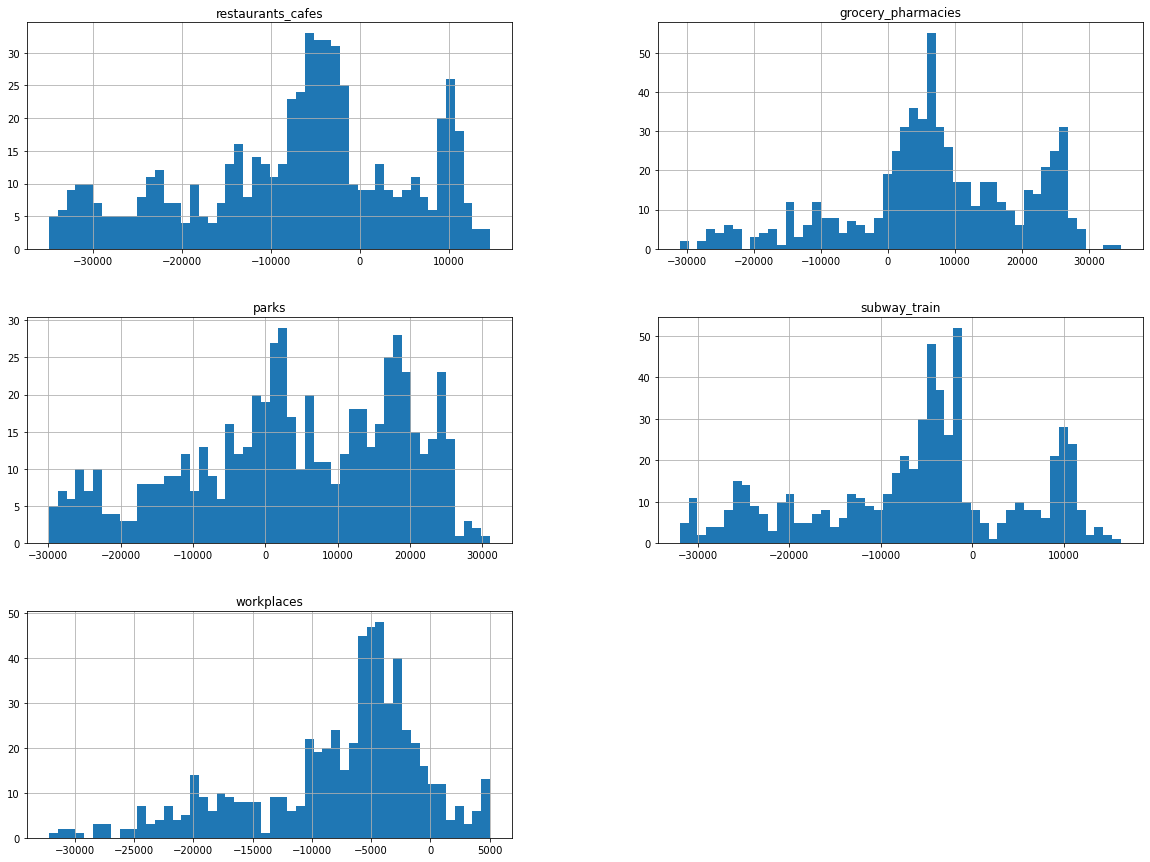

In [17]:
g_mob_filled[["restaurants_cafes",
    "grocery_pharmacies",
    "parks",
    "subway_train",
    "workplaces" ]].hist(bins=50, figsize=(20,15))
plt.title("mobility data histogram grafiği")
plt.show()

# T.C sağlık bakanlığı web sitesinden çekilen corona virüsü-vaka grafiğinin dataFrame'e eklenmesi:

In [98]:
import pandas as pd
covid_tr_data = pd.read_html('htmldeneme.html', encoding="utf-8")[0]
covid_tr_data=covid_tr_data[["Tarih", "Bugünkü Vaka Sayısı", "Bugünkü Hasta Sayısı", "Bugünkü Vefat Sayısı","Bugünkü İyileşen Sayısı" ]]
covid_tr_data.columns=[ "date", "daily_case","daily_patient", "daily_death", "daily_recovered"]

def date_set(date):
    splitted_date=date.split()
    mouth_number={
        'OCAK':"01",
        'ŞUBAT':"02",
        'MART':"03",
        'NİSAN':"04",
        'MAYIS':"05",
        'HAZİRAN':"06",
        'TEMMUZ':"07",
        'AĞUSTOS':"08",
        'EYLÜL':"09",
        'EKİM':"10",
        'KASIM':"11",
        'ARALIK':"12"
    }
    for mouth_name, mouth_no in mouth_number.items():
        if(splitted_date[1]==mouth_name):
            splitted_date[1]=mouth_no
            to_convert_datatime=splitted_date[2]+"-"+splitted_date[1]+"-"+splitted_date[0]
            return pd.to_datetime(to_convert_datatime)     
covid_tr_data["date"]=covid_tr_data["date"].apply(lambda x: date_set(x))
covid_tr_data=covid_tr_data[covid_tr_data.isnull().sum(axis=1)<3]
covid_tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 0 to 637
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             638 non-null    datetime64[ns]
 1   daily_case       395 non-null    float64       
 2   daily_patient    465 non-null    float64       
 3   daily_death      638 non-null    float64       
 4   daily_recovered  630 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 29.9 KB


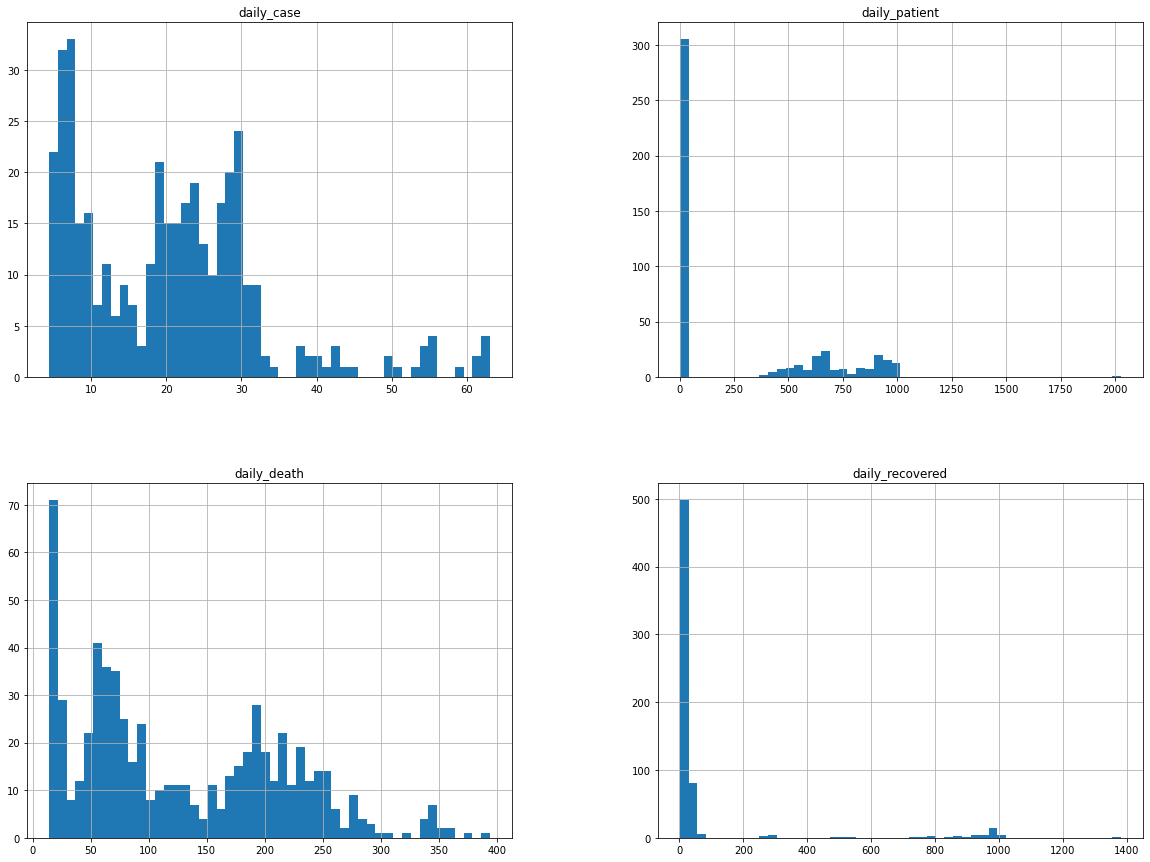

In [99]:
covid_tr_data.drop(["date"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

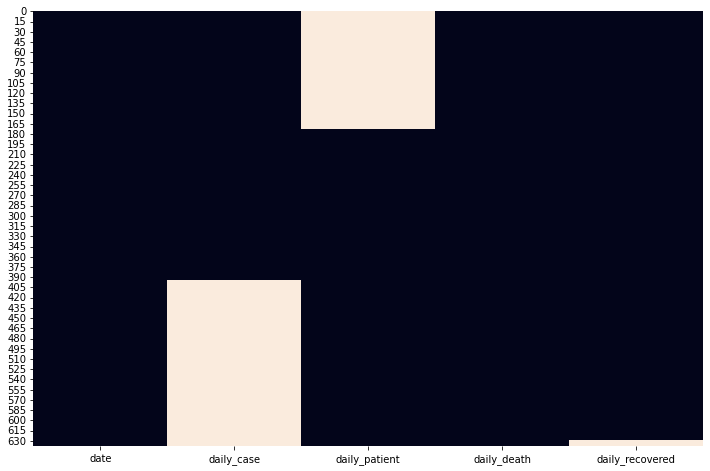

In [100]:
plt.figure(figsize=(12,8))

sns.heatmap(covid_tr_data.isnull(),cbar=False)

In [101]:
#covid_tr_data.head()

In [102]:
covid_tr_data[200:]

,date,daily_case,daily_patient,daily_death,daily_recovered
200,2021-06-07,5.647,495.000,91.0,6.576
201,2021-06-06,5.386,482.000,96.0,6.003
202,2021-06-05,6.126,542.000,92.0,7.161
203,2021-06-04,6.169,552.000,94.0,7.617
204,2021-06-03,6.602,563.000,114.0,8.540
...,...,...,...,...,...
633,2020-03-31,NaN,2.704,46.0,NaN
634,2020-03-30,NaN,1.610,37.0,NaN
635,2020-03-29,NaN,1.815,23.0,NaN
636,2020-03-28,NaN,1.704,16.0,NaN


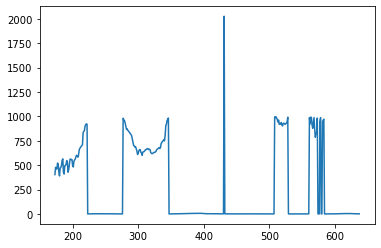

In [103]:
plt.plot(covid_tr_data.daily_patient)

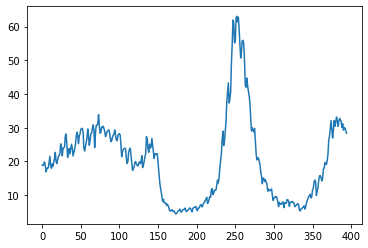

In [104]:
plt.plot(covid_tr_data.daily_case)

__Veride hasta sayısı binaltıyüz:1.600(1.6 olarak algılanacak şekilde, yüzelli: 150(yüzelli olarak algılanacak şekilde girilmiş. Bunun düzenleme:__

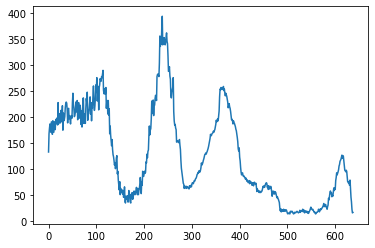

In [105]:
plt.plot(covid_tr_data.daily_death)

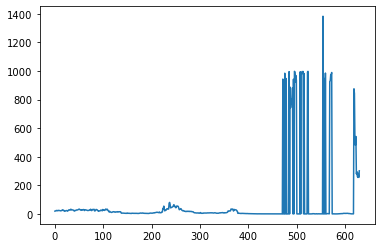

In [106]:
plt.plot(covid_tr_data.daily_recovered)

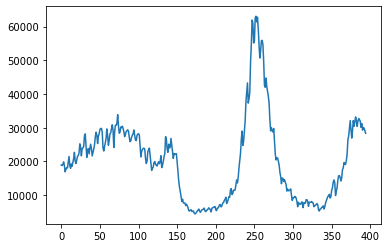

In [107]:
features_to_fix=["daily_case","daily_patient", "daily_death", "daily_recovered"]
#covid_tr_data[features_to_fix]=
covid_tr_data[features_to_fix]=covid_tr_data[features_to_fix].apply(lambda x :  x.apply(lambda k: k if( (k%1==0)) else(k*1000)))
plt.plot(covid_tr_data.daily_case)

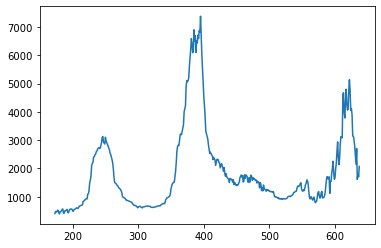

In [108]:
plt.plot(covid_tr_data.daily_patient)

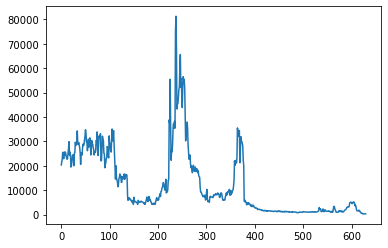

In [109]:
plt.plot(covid_tr_data.daily_recovered)

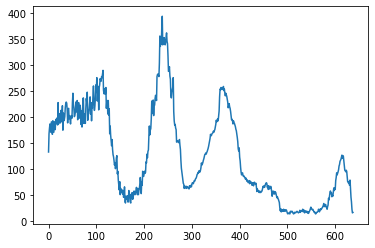

In [110]:
plt.plot(covid_tr_data.daily_death)

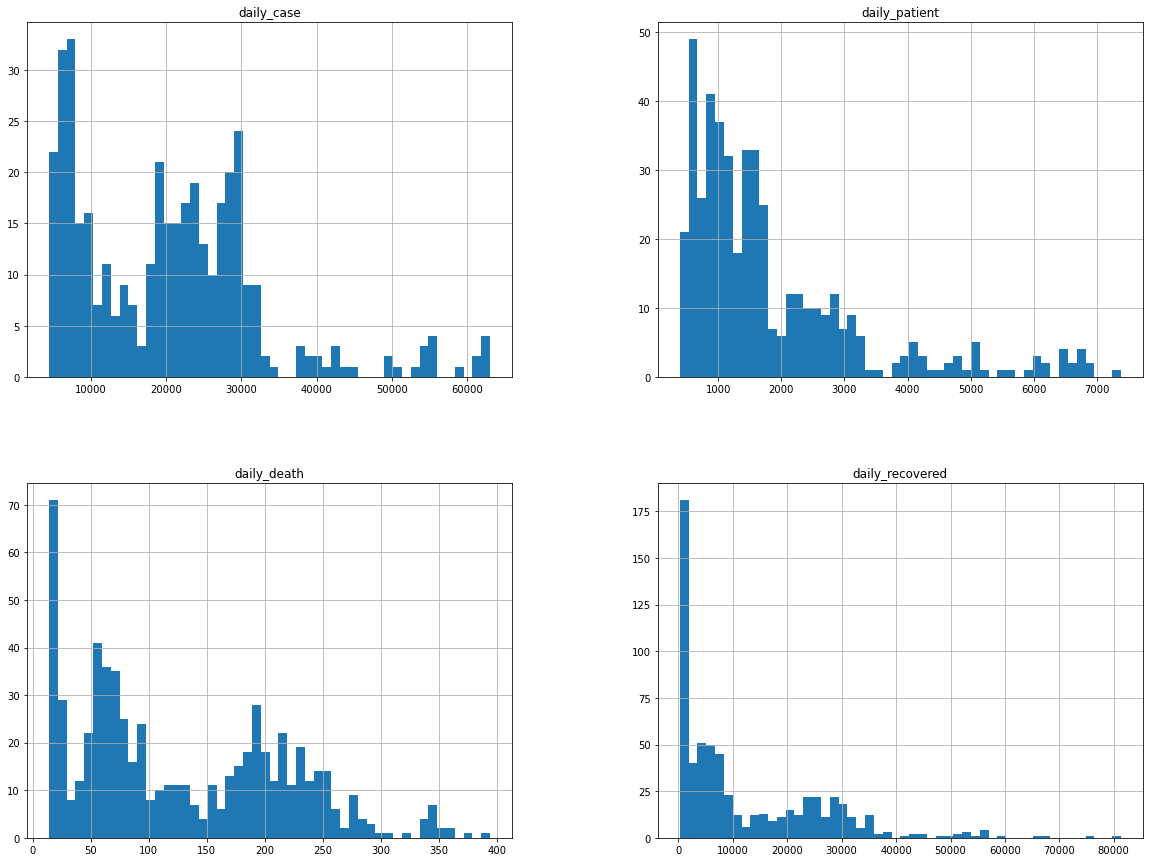

In [111]:
covid_tr_data.drop(["date"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()

__Eksik gözlem analizi__

In [112]:
names=list(covid_tr_data)
nparray_covid_df=np.array(covid_tr_data.loc[:, ["daily_case","daily_patient","daily_death"]])
covid_filled_arr=knnimput.KNN(k = 10).complete(nparray_covid_df)
covid_filled=covid_tr_data.copy()
covid_filled.loc[:, ["daily_case","daily_patient","daily_death"]]=covid_filled_arr
print(covid_filled.isnull().values.any())
covid_filled=covid_filled.groupby(by="date").mean()
covid_filled.head()

Imputing row 1/638 with 1 missing, elapsed time: 0.037
Imputing row 101/638 with 1 missing, elapsed time: 0.039
Imputing row 201/638 with 0 missing, elapsed time: 0.040
Imputing row 301/638 with 0 missing, elapsed time: 0.040
Imputing row 401/638 with 1 missing, elapsed time: 0.041
Imputing row 501/638 with 1 missing, elapsed time: 0.042
Imputing row 601/638 with 1 missing, elapsed time: 0.043
True


,daily_case,daily_patient,daily_death,daily_recovered
date,,,,
2020-03-27,6196.702348,2069.0,17.0,NaN
2020-03-28,6206.281869,1704.0,16.0,NaN
2020-03-29,6120.467640,1815.0,23.0,NaN
2020-03-30,5481.189405,1610.0,37.0,NaN
2020-03-31,7500.946217,2704.0,46.0,NaN


In [113]:
#covid_filled.daily_case=(covid_filled.daily_case*1000).astype("int32")
#covid_filled.daily_recovered=(covid_filled.daily_recovered*1000).astype("int32")

In [114]:
#g_mob_filled=g_mob.copy()
#print(g_mob_filled.isnull().values.any())
#g_mob_filled.iloc[:][features_to_fill]=filled_df_array
#print(g_mob_filled.isnull().values.any())
#g_mob_filled=g_mob_filled.groupby(by="date").sum()

## Merge 

In [115]:
covid_filled["date"]=pd.to_datetime(covid_filled.index)
covid_filled.index=range(0,covid_filled.shape[0])
#covid_filled.head(2)
g_mob_filled["date"]=g_mob_filled.index
g_mob_filled['date'] = pd.to_datetime(g_mob_filled.date)
g_mob_filled.index=range(0,g_mob_filled.shape[0])
#g_mob_filled.head()

In [118]:
mobility_death_data=pd.merge(covid_filled, g_mob_filled, on="date")
mobility_death_data

,daily_case,daily_patient,daily_death,daily_recovered,date,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
0,6196.702348,2069.000000,17.0,NaN,2020-03-27,-22811.916257,-9295.657739,-14488.347350,-22950.360220,-17510.988014
1,6206.281869,1704.000000,16.0,NaN,2020-03-28,-24466.136235,-11098.648209,-18827.574722,-23132.976682,-15290.610430
2,6120.467640,1815.000000,23.0,NaN,2020-03-29,-26492.925708,-14937.433961,-20738.705978,-25110.844184,-16452.771996
3,5481.189405,1610.000000,37.0,NaN,2020-03-30,-22417.446250,-10132.792575,-13889.522040,-23492.284080,-17997.000000
4,7500.946217,2704.000000,46.0,NaN,2020-03-31,-23375.218754,-11000.849163,-16058.771620,-23964.404904,-18675.000000
...,...,...,...,...,...,...,...,...,...,...
553,28873.000000,5725.116058,210.0,26224.0,2021-10-01,10032.138595,28341.801322,17388.032059,9703.307668,1276.000000
554,27973.000000,5966.112388,203.0,22110.0,2021-10-02,9180.330620,23201.766227,16160.184049,9010.811752,689.000000
555,27351.000000,6335.576422,194.0,22004.0,2021-10-03,6788.159097,18521.319688,17286.890103,7815.287463,-625.000000
556,28810.000000,4698.509257,248.0,33152.0,2021-10-04,11206.363842,27149.481841,17731.936199,9661.911420,912.000000


In [121]:
mobility_death_data=mobility_death_data.groupby([pd.Grouper(key='date', freq='W-MON')]).sum().reset_index()
mobility_death_data["week"]=mobility_death_data.index
mobility_death_data

,date,daily_case,daily_patient,daily_death,daily_recovered,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces,week
0,2020-03-30,24004.641262,7198.000000,93.0,0.0,-96188.424450,-45464.532485,-67944.150090,-94686.465165,-67251.370440,0
1,2020-04-06,132089.832164,19390.000000,481.0,842.0,-174579.793330,-83076.104824,-126381.009591,-177429.047799,-131359.973995,1
2,2020-04-13,151808.711629,30832.000000,647.0,2631.0,-184748.904348,-93838.686310,-128767.661573,-183651.597055,-144653.455031,2
3,2020-04-20,177596.994999,29931.000000,844.0,9473.0,-171590.219826,-69679.556442,-112135.272452,-172501.591345,-135205.738924,3
4,2020-04-27,164304.084311,21281.000000,760.0,20361.0,-180565.787415,-82555.283539,-128136.346322,-182229.376444,-150354.405485,4
...,...,...,...,...,...,...,...,...,...,...,...
76,2021-09-13,163848.000000,26534.096847,1740.0,212722.0,69362.800164,173671.562427,139781.601655,63770.304715,-7904.000000,76
77,2021-09-20,192083.000000,32858.452403,1688.0,192305.0,69027.910935,174514.153248,141845.477871,66130.007562,-9213.000000,77
78,2021-09-27,191741.000000,36450.931157,1567.0,157416.0,67160.563673,173108.484450,129638.152248,68991.547351,4462.000000,78
79,2021-10-04,200389.000000,38208.322773,1537.0,196963.0,66283.855762,175522.273476,120913.674313,66312.657478,6597.000000,79


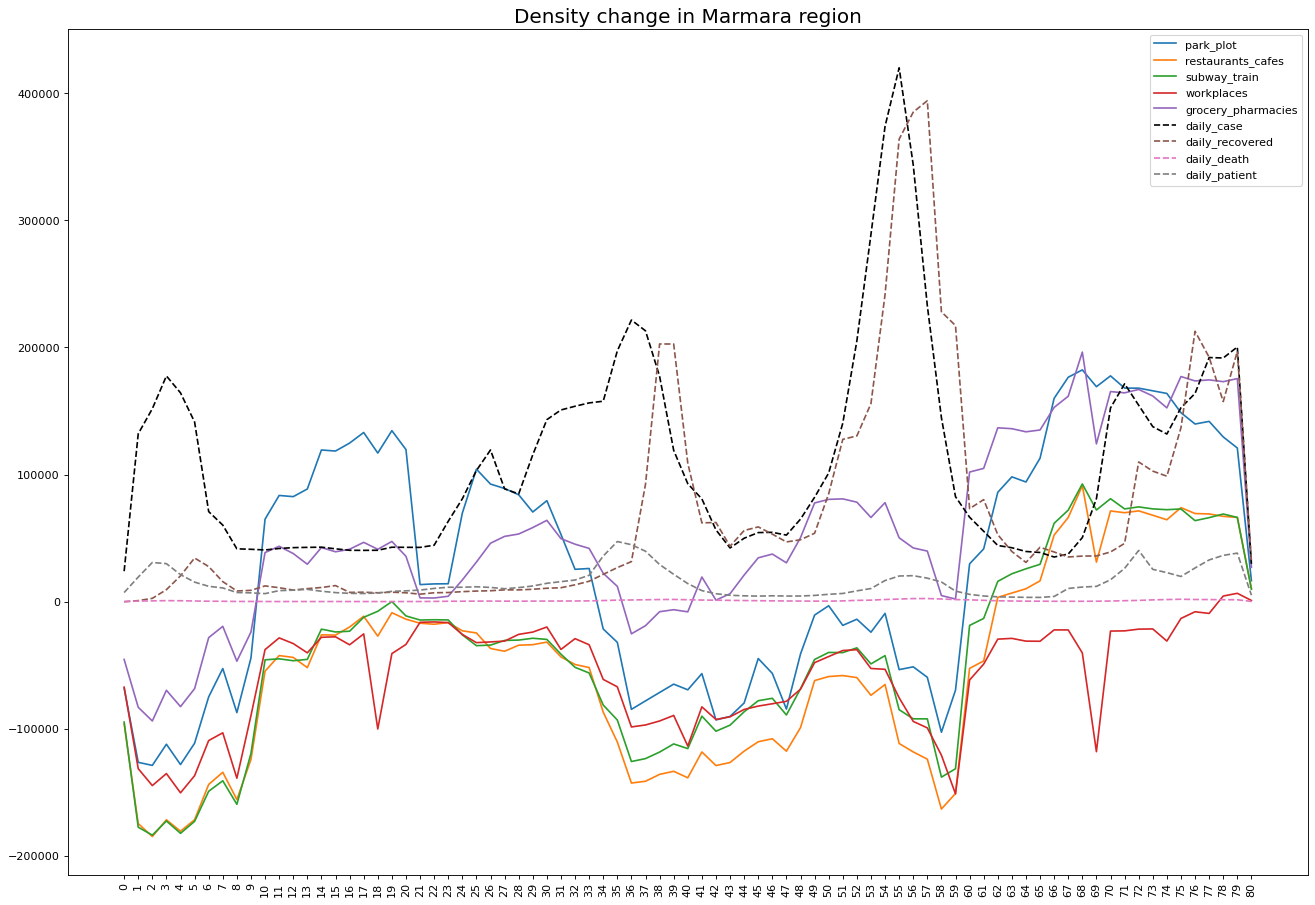

In [122]:
plt.figure(figsize=(20,14), dpi=80)
X = mobility_death_data.week # datanın indexi direkt month olduğu için
parks_plot = plt.plot(X,mobility_death_data.parks)
restaurants_cafes = plt.plot(X,mobility_death_data.restaurants_cafes)
subway_train = plt.plot(X,mobility_death_data.subway_train)
workplaces = plt.plot(X,mobility_death_data.workplaces)
grocery_pharmacies = plt.plot(X,mobility_death_data.grocery_pharmacies)
daily_case = plt.plot(X,mobility_death_data.daily_case, "--", color="#000000")
daily_recovered = plt.plot(X,mobility_death_data.daily_recovered, "--")
daily_death = plt.plot(X,mobility_death_data.daily_death, "--")
daily_patient = plt.plot(X,mobility_death_data.daily_patient, "--")


plt.title('Density change in Marmara region', fontsize=18)
plt.xticks(rotation=90)
plt.xticks(X)
# Modify legend
plt.legend([ parks_plot[0], restaurants_cafes[0], subway_train[0], workplaces[0], grocery_pharmacies[0], daily_case[0], daily_recovered[0], daily_death[0], daily_patient[0]],
           [ 'park_plot', 'restaurants_cafes', 'subway_train', 'workplaces', 'grocery_pharmacies', 'daily_case', 'daily_recovered', 'daily_death', "daily_patient"]) 
plt.show()

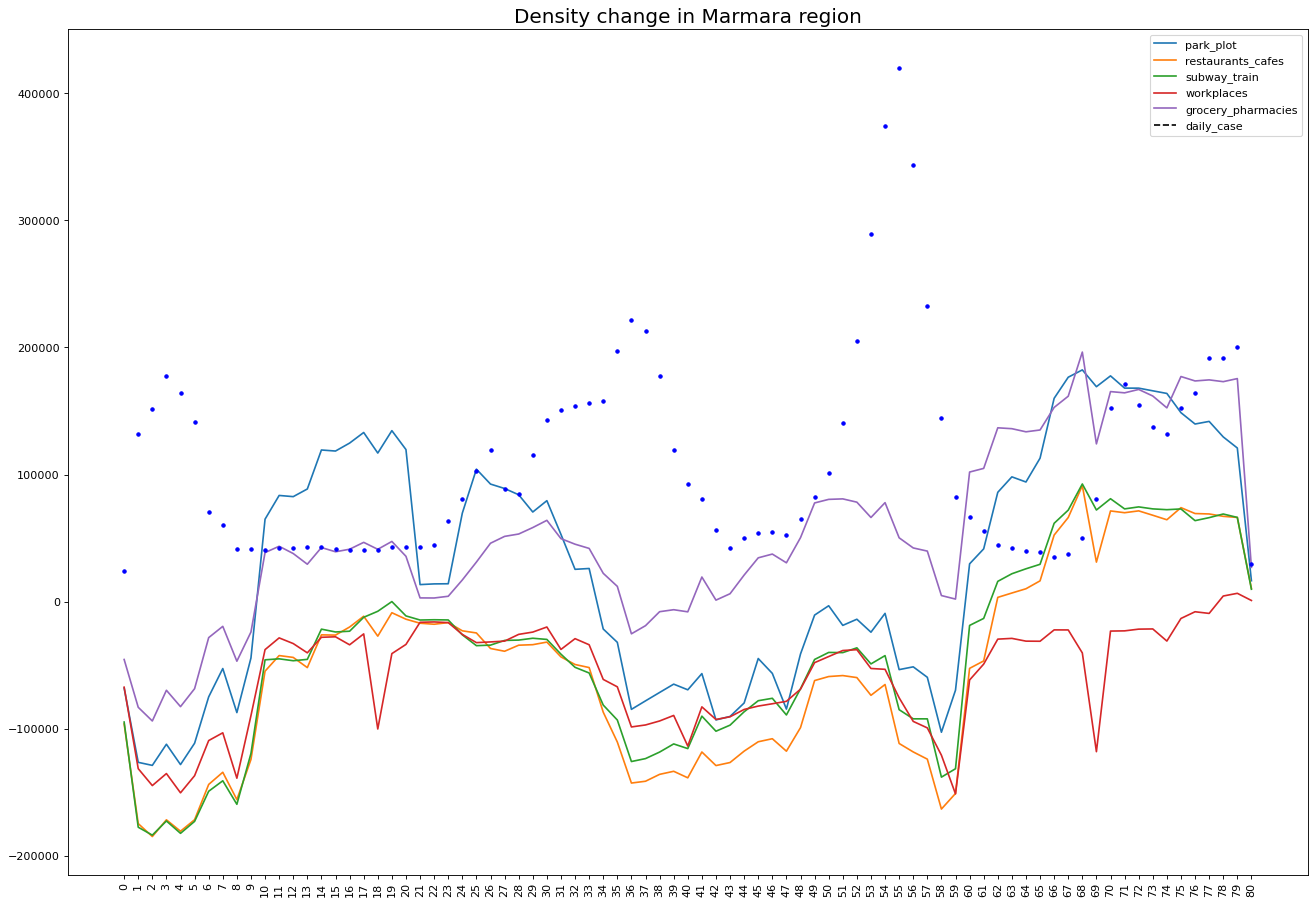

In [123]:
plt.figure(figsize=(20,14), dpi=80)
X = mobility_death_data.week # datanın indexi direkt month olduğu için
parks_plot = plt.plot(X,mobility_death_data.parks, 
                      X,mobility_death_data.restaurants_cafes,
                      X,mobility_death_data.subway_train,
                      X,mobility_death_data.workplaces,
                      X,mobility_death_data.grocery_pharmacies,
                      X,mobility_death_data.daily_case, "b.")



plt.title('Density change in Marmara region', fontsize=18)
plt.xticks(rotation=90)
plt.xticks(X)
# Modify legend
plt.legend([ parks_plot[0], restaurants_cafes[0], subway_train[0], workplaces[0], grocery_pharmacies[0], daily_case[0]],
           [ 'park_plot', 'restaurants_cafes', 'subway_train', 'workplaces', 'grocery_pharmacies', 'daily_case']) 
plt.show()

In [124]:
#mobility_death_data=mobility_death_data.groupby([pd.Grouper(key='date', freq='W-MON')]).mean().reset_index()
#mobility_death_data["week"]=mobility_death_data.index
#mobility_death_data.head(4)

In [209]:
#kaç hafta sonra vaka-mobility arasında en büyük korelasyon elde ediliyor=
best_model=object
best_score=float('inf')
best_week=0
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

def corr_after_week(week):
    global best_week, best_score, best_model
    mobility_death_data_drpd=mobility_death_data[["daily_case","restaurants_cafes","grocery_pharmacies","parks","subway_train", "workplaces" ]]
    cases_week_ago=np.array(mobility_death_data_drpd.daily_case.iloc[week:])
    mobility_death_data_drpd=mobility_death_data_drpd[:-week]
    
    y=cases_week_ago
    X=mobility_death_data_drpd.drop(["daily_case"], axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)    

    
    #print(np.absolute(corr_matrix["daily_case"]).sort_values(ascending=False))
    xgb_grid={
        'colsample_bytree':[0.4,0.6,0.9],
        'n_estimators':[200, 500, 1000],
        'max_depth':[2,4,6],
        'learning_rate':[0.01, 0.1]
    }
    import xgboost as xgb
    
    xgboost=xgb.XGBRegressor()
    xgb_cv=GridSearchCV(
        xgboost,
        param_grid=xgb_grid,
        cv=5, 
        n_jobs=-1,
        verbose=2
    )
    xgb_cv.fit(X,y)
    xgb_best=xgb_cv.best_estimator_
    
    xgb_best.fit(X,y)
    y_preds=xgb_best.predict(X)
    from sklearn.metrics import mean_squared_error
    val_score=np.sqrt(-np.mean(cross_val_score(xgb_best, X, y, cv=2, scoring="neg_mean_squared_error")))
    print(val_score, best_score, week, "\n")
    if(val_score<best_score):
        print("girildi",val_score, ">",best_score)
        best_model=xgb_best
        best_week=week
        best_score=val_score
        
for i in range(1,8):
    corr_after_week(i)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
87462.20789213262 inf 1 

girildi 87462.20789213262 > inf
Fitting 5 folds for each of 54 candidates, totalling 270 fits
81003.77379065822 87462.20789213262 2 

girildi 81003.77379065822 > 87462.20789213262
Fitting 5 folds for each of 54 candidates, totalling 270 fits
80736.89467782126 81003.77379065822 3 

girildi 80736.89467782126 > 81003.77379065822
Fitting 5 folds for each of 54 candidates, totalling 270 fits
81496.4854819015 80736.89467782126 4 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
82301.91254863498 80736.89467782126 5 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
86863.79385235732 80736.89467782126 6 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
93098.84320379191 80736.89467782126 7 



In [210]:
print("best_week:", best_week,"\nbest_model:", best_model)

best_week: 3 
best_model: XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)


In [255]:
mobility_death_data_drpd=mobility_death_data[["daily_case","restaurants_cafes","grocery_pharmacies","parks","subway_train", "workplaces" ]]
cases_week_ago=np.array(mobility_death_data_drpd.daily_case.iloc[best_week:])
mobility_death_data_drpd=mobility_death_data_drpd[:-best_week]
y=cases_week_ago
X=mobility_death_data_drpd.drop(["daily_case"], axis=1)

best_model.fit(X,y)
y_preds= cross_val_predict(best_model, X, y, cv=6)


np.sqrt(-np.mean(cross_val_score(best_model, X, y, cv=6, scoring="neg_mean_squared_error")))

76119.8888492755

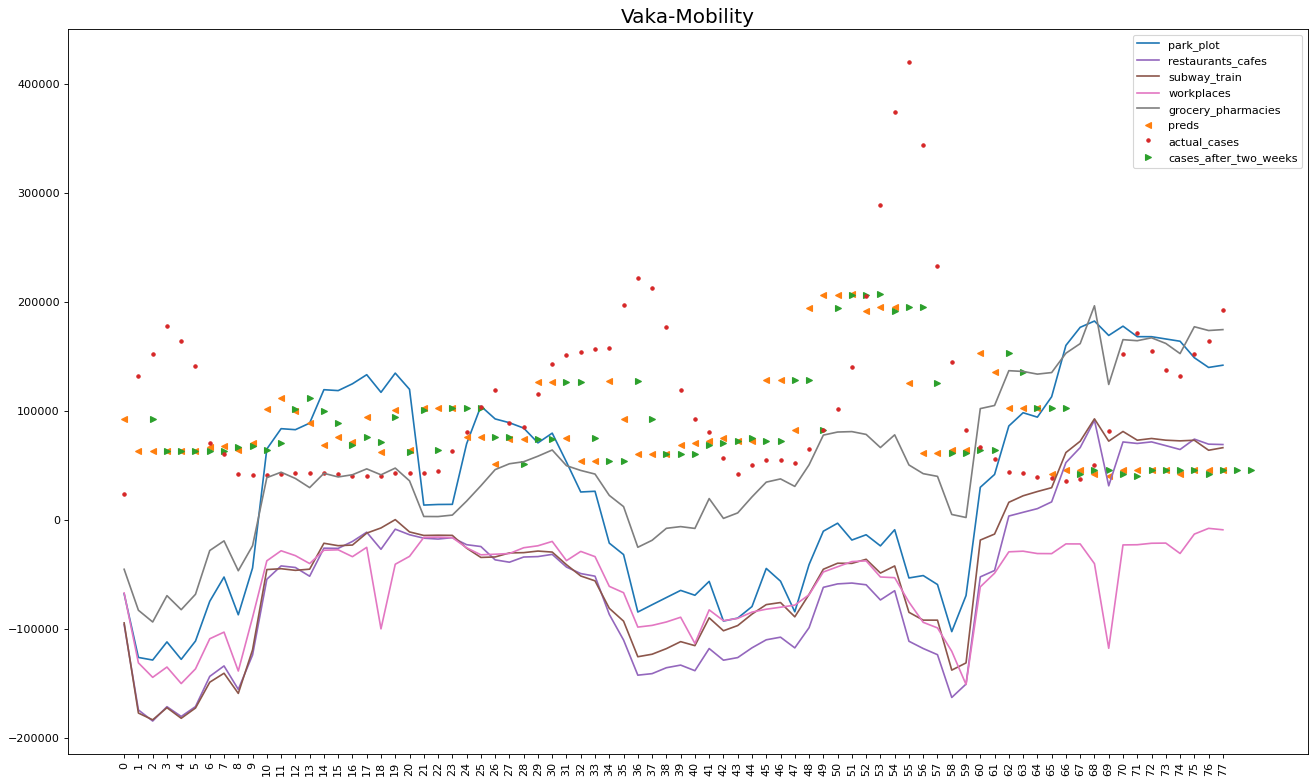

In [257]:
plt.figure(figsize=(20,12), dpi=80)
X = mobility_death_data_drpd.index # datanın indexi direkt month olduğu için
parks_plot = plt.plot(X,mobility_death_data_drpd.parks)
preds = plt.plot(X,y_preds, "<")
cases_after_two_weeks = plt.plot(X+2,y_preds, ">")


actual_cases = plt.plot(X,mobility_death_data[:mobility_death_data_drpd.shape[0]].daily_case, ".",)
restaurants_cafes = plt.plot(X,mobility_death_data_drpd.restaurants_cafes)
subway_train = plt.plot(X,mobility_death_data_drpd.subway_train)
workplaces = plt.plot(X,mobility_death_data_drpd.workplaces)
grocery_pharmacies = plt.plot(X,mobility_death_data_drpd.grocery_pharmacies)


plt.title('Vaka-Mobility', fontsize=18)
plt.xticks(rotation=90)
plt.xticks(X)
# Modify legend
plt.legend([ parks_plot[0], restaurants_cafes[0], subway_train[0], workplaces[0], grocery_pharmacies[0], preds[0],actual_cases[0],cases_after_two_weeks[0] ],
           [ 'park_plot', 'restaurants_cafes', 'subway_train', 'workplaces', 'grocery_pharmacies', 'preds', "actual_cases", "cases_after_two_weeks"]) 
plt.show()

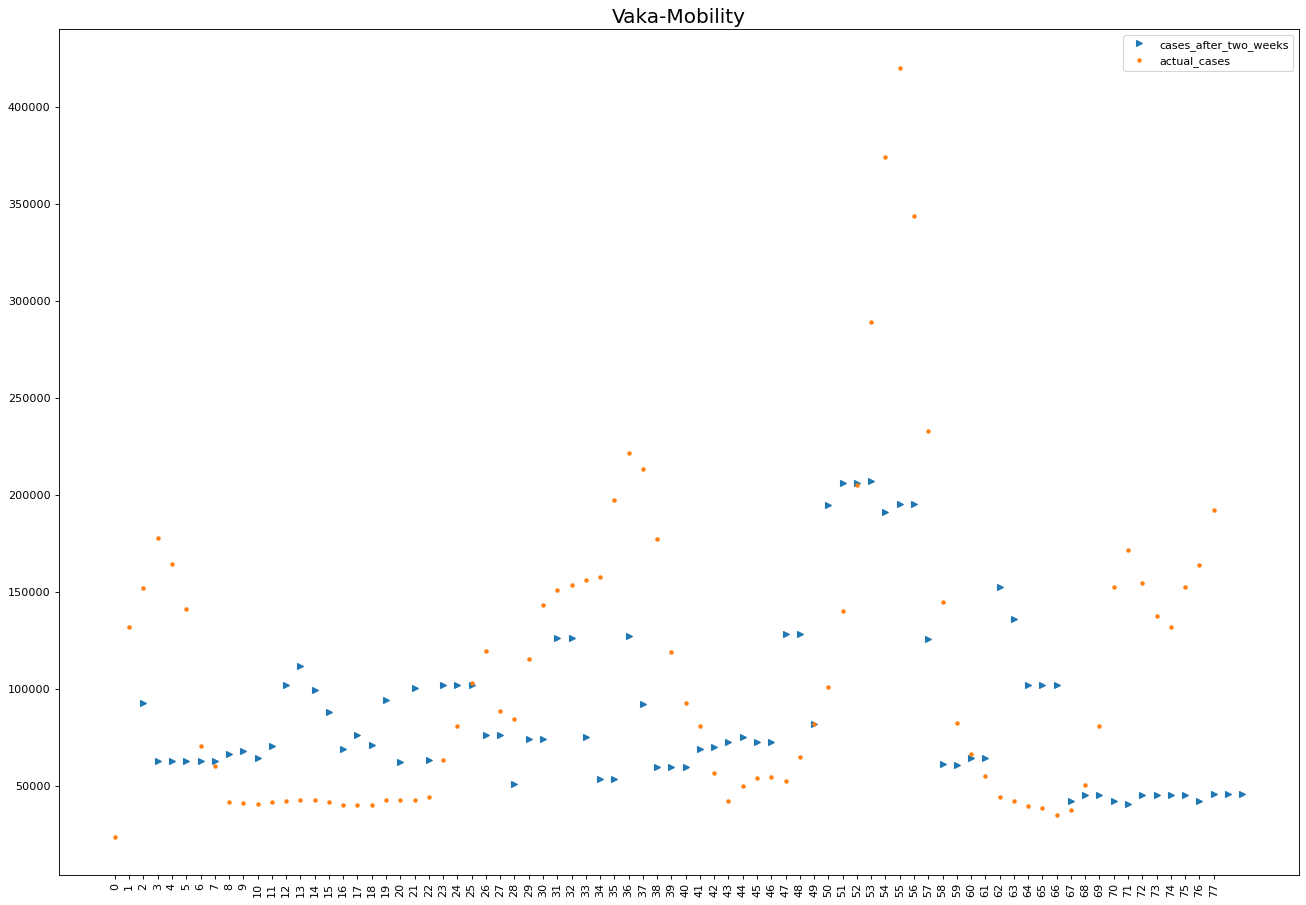

In [258]:
plt.figure(figsize=(20,14), dpi=80)
X = mobility_death_data_drpd.index # datanın indexi direkt month olduğu için

cases_after_two_weeks = plt.plot(X+2,y_preds, ">")
actual_cases = plt.plot(X,mobility_death_data[:mobility_death_data_drpd.shape[0]].daily_case, ".",)


plt.title('Vaka-Mobility', fontsize=18)

plt.xticks(rotation=90)
plt.xticks(X)
# Modify legend
plt.legend([cases_after_two_weeks[0],actual_cases[0] ],
           ['cases_after_two_weeks', "actual_cases"]) 
plt.show()

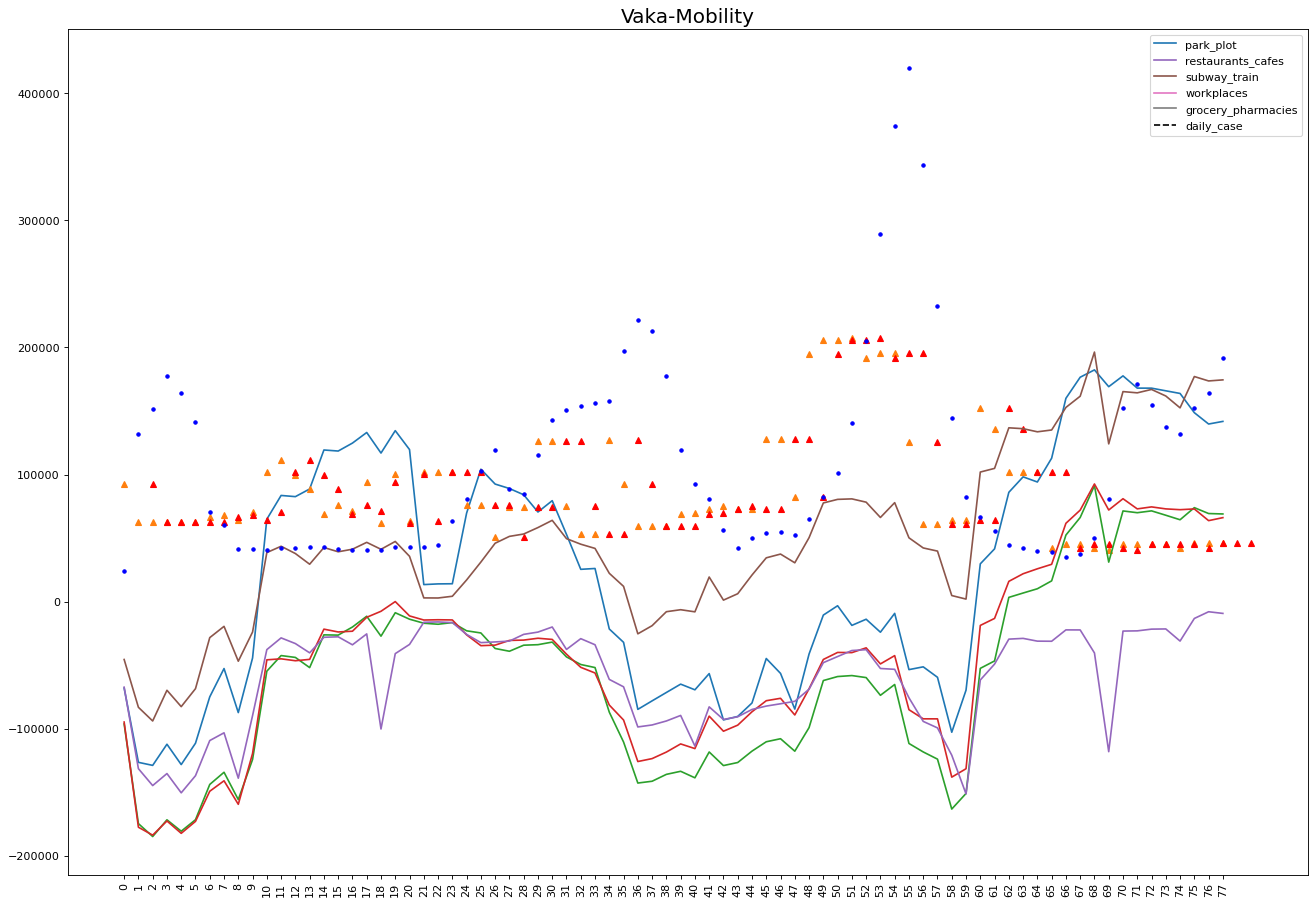

In [259]:
plt.figure(figsize=(20,14), dpi=80)
X = mobility_death_data_drpd.index # datanın indexi direkt month olduğu için
parks_plot = plt.plot(X,mobility_death_data_drpd.parks, 
                      X,y_preds, "^",
                      X+2,y_preds, "r^",
                      X,mobility_death_data_drpd.restaurants_cafes, 
                      X,mobility_death_data_drpd.subway_train,
                      X,mobility_death_data_drpd.workplaces,
                      X,mobility_death_data_drpd.grocery_pharmacies,
                      X,mobility_death_data[:mobility_death_data_drpd.shape[0]].daily_case, "b.")



plt.title('Vaka-Mobility', fontsize=18)

plt.xticks(rotation=90)
plt.xticks(X)
# Modify legend
plt.legend([ parks_plot[0], restaurants_cafes[0], subway_train[0], workplaces[0], grocery_pharmacies[0], daily_case[0]],
           [ 'park_plot', 'restaurants_cafes', 'subway_train', 'workplaces', 'grocery_pharmacies', 'daily_case']) 
plt.show()

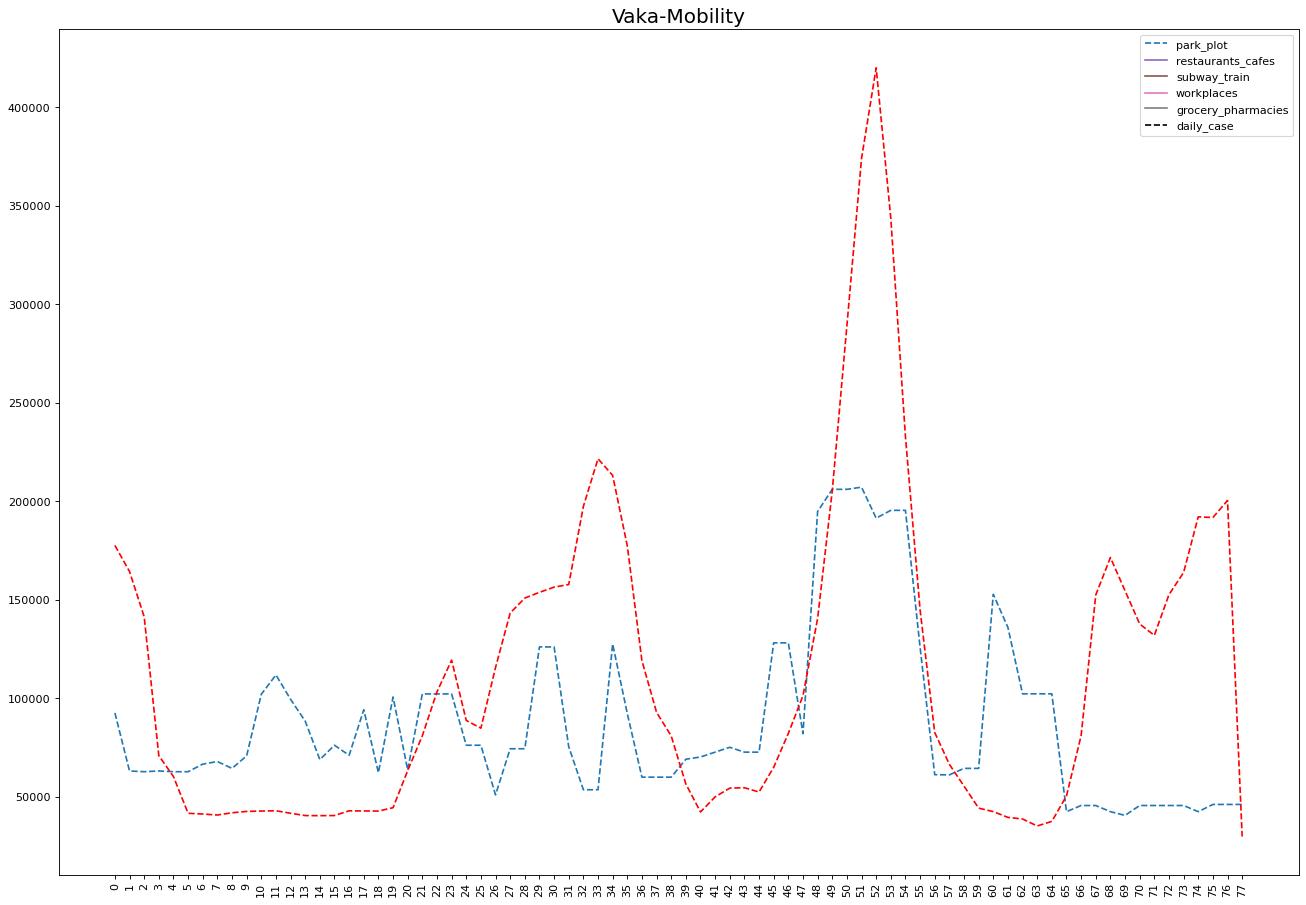

In [260]:
plt.figure(figsize=(20,14), dpi=80)
X = mobility_death_data_drpd.index # datanın indexi direkt month olduğu için
parks_plot = plt.plot(
                      X,y_preds, "--",
                      X,y, "r--")

plt.title('Vaka-Mobility', fontsize=18)

plt.xticks(rotation=90),
plt.xticks(X)
# Modify legend
plt.legend([ parks_plot[0], restaurants_cafes[0], subway_train[0], workplaces[0], grocery_pharmacies[0], daily_case[0]],
           [ 'park_plot', 'restaurants_cafes', 'subway_train', 'workplaces', 'grocery_pharmacies', 'daily_case']) 
plt.show()

In [ ]:
mean_squared_error(y_preds, y)